In [1]:
import sys
sys.path.append('../../src/utils/')

from galenv import *

from astroquery.irsa import Irsa
Irsa.ROW_LIMIT = 10000

%matplotlib inline

In [2]:
def plot_cone(coord, theta, res, xSize=7.5, ySize=7.5, title='', show=True, savefig=False, imgname="plot.png"):
        '''Only cone
        coord = astropy coordinates
        theta = Cone angle
        res = result catalog
        '''
        ra = coord.ra.value
        dec = coord.dec.value

        fig = plt.figure(figsize=(xSize, ySize))        
        gs = gridspec.GridSpec(1, 1)
        
        ax = plt.subplot(gs[0])
        # ax.axis('equal')
        limangle = 1.5*theta
        ax.set_xlim((ra-limangle, ra+limangle))
        ax.set_ylim((dec-limangle, dec+limangle))
        
        # Central position/object
        ax.plot(ra, dec, 'ro', alpha=0.5)
        
        # Catalog object
        ax.plot(res['ra'], res['dec'], 'k.')
        
        plt.gca().invert_xaxis() # RA from E to W
        ax.set_xlabel('RA (deg)')
        ax.set_ylabel('DEC (deg)')
        plt.title(title)

        # Circle
        # it is wrong if I draw a circle around (ra, dec) with radius theta
        # due to small circle in celestial sphere for DEC
        circle = plt.Circle((ra, dec), theta, fc='none', ec='black')
        ax.add_artist(circle)
        
        fig.tight_layout()

        if savefig:
            plt.savefig(imgname)

        if show:
            plt.show()

        plt.close()
        


In [3]:
ga = Galenv()

## Check using name

In [4]:
def search_and_plot(objname, ra, dec, tangential_dist, cat='fp_psc'):
    try:
        print(objname)
        z, v0, _ra, _dec = ga.queryobject_byname(objname)
        print("NED (z, v, ra, dec): ", z, v0, _ra, _dec)

        obj_coord = coordinates.SkyCoord(ra=ra, dec=dec, unit=(u.deg, u.deg))

        dA, theta = ga.calc_dA_theta(z, tangential_dist)
        print("From redshift & tangential_dist (dA, theta):", dA, theta)
        
        result = Irsa.query_region(obj_coord, catalog=cat, spatial="Cone", radius= theta * u.deg)
        
        plot_cone(obj_coord, theta, result, savefig=True, imgname=objname + '.png')
        
        return result
        print("----")
        
    except:
        print("error! maybe can not identify from name") 
        print("----")

PKS J2253+1608
NED (z, v, ra, dec):  0.859 257522.0 343.49062 16.14821
From redshift & tangential_dist (dA, theta): 1629.9307676687627 0.2636420852173554


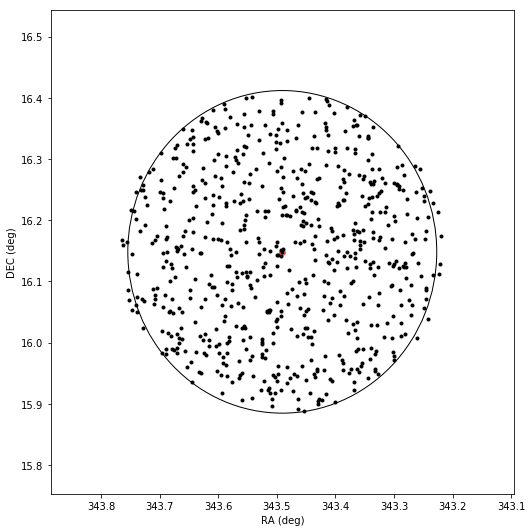

In [5]:
objname = 'PKS J2253+1608'
ra_center = 343.49061
dec_center = 16.148211
radius = 7.5 # in Mpc
z = 0.859
data = search_and_plot(objname, ra_center, dec_center, radius, 'fp_psc')

In [6]:
data

ra,dec,clon,clat,err_maj,err_min,err_ang,designation,j_m,j_cmsig,j_msigcom,j_snr,h_m,h_cmsig,h_msigcom,h_snr,k_m,k_cmsig,k_msigcom,k_snr,ph_qual,rd_flg,bl_flg,cc_flg,ndet,gal_contam,mp_flg,hemis,xdate,scan,glon,glat,a,dist_opt,phi_opt,b_m_opt,vr_m_opt,nopt_mchs,ext_key,dist,angle,j_h,h_k,j_k,id
deg,deg,,,arcs,arcs,deg,,mag,mag,mag,,mag,mag,mag,,mag,mag,mag,,,,,,,,,,,,deg,deg,,arcs,deg,mag,mag,,,arcs,deg,,,,
float64,float64,object,object,float64,float64,int32,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,int32,int32,object,object,int32,float64,float64,object,float64,int32,float64,float64,int32,int32,float64,float64,float64,float64,float64,object
343.491,16.148,22h53m57.75s,16d08m53.63s,0.07,0.06,90,22535774+1608536,14.494,0.027,0.03,61.6,13.855,0.029,0.03,52.7,13.061,0.026,0.027,55.9,AAA,222,111,000,665566,0,0,n,1998-10-01,73,86.111,-38.184,U,0.0,115,14.8,14.1,1,--,0.083101,29.956018,0.639,0.794,1.433,0
343.492,16.152,22h53m58.16s,16d09m06.78s,0.07,0.06,90,22535816+1609067,11.844,0.017,0.021,707.7,11.339,0.021,0.023,535.0,11.239,0.019,0.021,299.1,AAA,222,111,000,666666,0,0,n,1998-10-01,73,86.115,-38.182,U,0.8,104,14.3,13.0,1,--,14.524088,24.472708,0.505,0.1,0.605,1
343.490,16.152,22h53m57.56s,16d09m08.57s,0.27,0.25,106,22535755+1609085,16.164,0.094,0.095,13.2,16.003,0.177,0.177,7.3,15.724,0.237,0.238,4.8,ACD,222,111,ccc,060606,0,0,n,1998-10-01,73,86.113,-38.18,U,1.2,284,16.7,16.1,1,--,15.262256,349.610108,0.161,0.279,0.44,2
343.493,16.141,22h53m58.37s,16d08m27.05s,0.07,0.06,90,22535836+1608270,14.8,0.035,0.037,46.5,14.103,0.038,0.039,42.0,13.838,0.04,0.041,27.3,AAA,222,111,000,666646,0,0,n,1998-10-01,73,86.108,-38.191,U,1.0,172,18.7,16.9,1,--,27.969178,161.413114,0.697,0.265,0.962,3
343.497,16.142,22h53m59.33s,16d08m32.80s,0.08,0.06,90,22535933+1608328,15.616,0.066,0.067,21.9,15.064,0.078,0.078,17.3,14.725,0.092,0.092,12.1,AAA,222,111,000,562616,0,0,n,1998-10-01,73,86.114,-38.192,U,0.5,93,19.7,17.8,1,--,30.858459,132.263622,0.552,0.339,0.891,4
343.499,16.143,22h53m59.74s,16d08m33.12s,0.28,0.26,133,22535974+1608331,16.162,0.09,0.091,13.3,15.66,0.12,0.12,10.0,15.675,0.226,0.227,5.0,ABD,222,111,000,061606,0,0,n,1998-10-01,73,86.116,-38.193,U,0.5,142,17.4,16.7,1,--,35.299853,125.369099,0.502,-0.015,0.487,5
343.501,16.158,22h54m00.21s,16d09m29.41s,0.22,0.21,86,22540021+1609294,16.827,0.154,0.155,7.2,16.046,0.163,0.164,7.0,15.275,--,--,--,BCU,220,110,000,060600,0,0,n,1998-10-01,73,86.129,-38.181,0,--,--,--,--,0,--,50.450937,44.711647,0.781,--,--,6
343.500,16.165,22h53m59.94s,16d09m54.03s,0.07,0.06,90,22535994+1609540,14.215,0.025,0.028,79.7,13.795,0.026,0.027,55.7,13.641,0.046,0.047,32.7,AAA,222,111,000,666666,0,0,n,1998-10-01,73,86.132,-38.175,U,0.7,77,16.4,15.4,1,--,68.238247,27.605575,0.42,0.154,0.574,7


In [7]:
def check_overdensity(data, ra_center, dec_center, z, rmin, rmax):
    dAmin, thetamin = ga.calc_dA_theta(z, rmin)
    dAmax, thetamax = ga.calc_dA_theta(z, rmax)
    
    inside = []
    outside = []
    
    for idata in data:
        ra_obj = idata['ra']
        dec_obj = idata['dec']
        obj =  coordinates.SkyCoord(ra=ra_obj, dec=dec_obj, unit=(u.deg, u.deg))
        center = coordinates.SkyCoord(ra=ra_center, dec=dec_center, unit=(u.deg, u.deg))

        dist = center.separation(obj)
        dist = dist.value
        if dist < thetamin:
            inside.append(idata)
        if dist > thetamin and dist < thetamax:
            outside.append(idata)
    
    return inside, outside, thetamin, thetamax

In [8]:
inside, outside, thetamin, thetamax = check_overdensity(data, ra_center, dec_center, z, 0.5, 1.0)

In [9]:
number_inside = len(inside)
number_outside = len(outside)
area_inside = np.pi * thetamin**2
area_outside = np.pi * (thetamax**2 - thetamin**2)

density_inside = number_inside/area_inside
density_outside = number_outside/area_outside

In [10]:
print(number_inside, number_outside, area_inside, area_outside)

7 8 0.0009705028843443482 0.002911508653033045


In [11]:
print(density_inside, density_outside)
print(density_inside/density_outside)

7212.755482668201 2747.7163743497904
2.6250000000000004
